In [1]:
import numpy as np
from sklearn.decomposition import KernelPCA
import matplotlib.pyplot as plt
from time import perf_counter

## Creating Data

Let's look at a cloud of data points surrounded by a circle. For this example, for each entry in the inner cloud is drawn from a $N(0,0.01)$, and each entry of the outer circle is sampled from a unit circle, with $N(0,0.01)$ noise added to each coordinate.

In [2]:
sampling_size = 1000

sample = np.arange(sampling_size) * (np.pi/50)
outer_cloud = np.concatenate((np.expand_dims(np.cos(sample),1), np.expand_dims(np.sin(sample),1)), axis=1) + 0.1 * np.random.randn(sampling_size, 2)

inner_cloud = 0.1 * np.random.randn(sampling_size,2)

data = np.concatenate((outer_cloud, inner_cloud), axis=0)
colormap = np.concatenate((np.zeros(sampling_size),np.ones(sampling_size)))

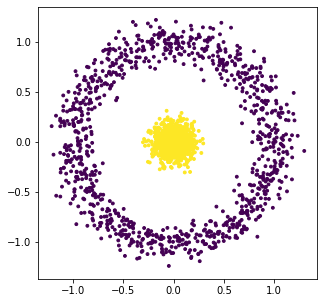

In [3]:
plt.figure(figsize=(5,5))
plt.scatter(data.T[0], data.T[1], s=8, c=colormap)


### Some embeddings of this data

In [4]:
emb = np.empty((5, 2*sampling_size, 2))

In [5]:
emb[0] = KernelPCA(n_components=2, kernel='linear').fit_transform(data)
emb[1] = KernelPCA(n_components=2, kernel='poly').fit_transform(data)
emb[2] = KernelPCA(n_components=2, kernel='rbf').fit_transform(data)
emb[3] = KernelPCA(n_components=2, kernel='sigmoid').fit_transform(data)
emb[4] = KernelPCA(n_components=2, kernel='cosine').fit_transform(data)

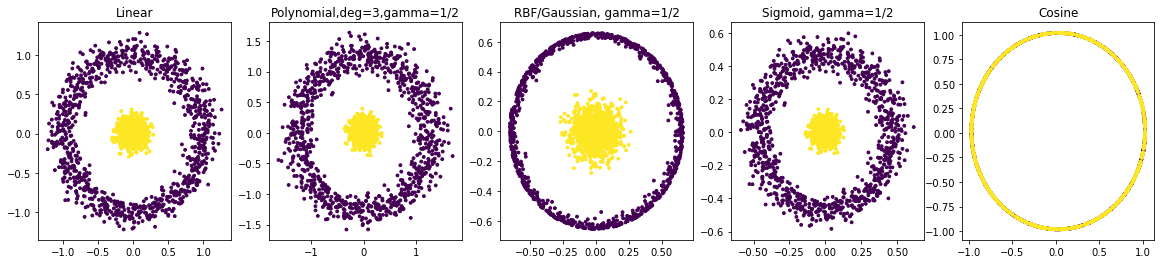

In [6]:
desc = ['Linear','Polynomial,deg=3,gamma=1/2', 'RBF/Gaussian, gamma=1/2', 'Sigmoid, gamma=1/2', 'Cosine']

fig,axes = plt.subplots(1,5, figsize=(20,4))
for i,ax in enumerate(axes.flat):
    ax.scatter(emb[i].T[0], emb[i].T[1], s=8, c=colormap)
    ax.set_title(desc[i])


### Varying Gamma for RBF (Gaussian) Kernel

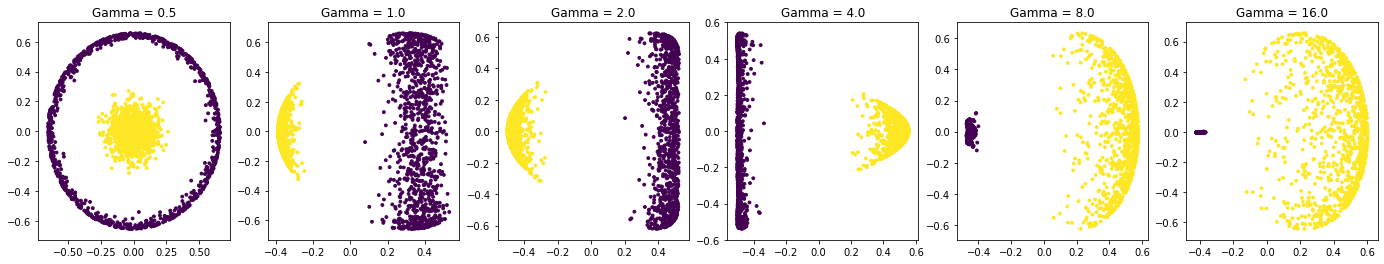

In [7]:
gamma_vals = np.asarray([0.5, 1, 2, 4, 8, 16])

emb = np.empty((gamma_vals.shape[0], 2*sampling_size, 2))

for i in range(gamma_vals.shape[0]):
    emb[i] = KernelPCA(n_components=2, kernel='rbf', gamma=gamma_vals[i]).fit_transform(data)

fig,axes = plt.subplots(1,gamma_vals.shape[0], figsize=(4*gamma_vals.shape[0],4))
for i,ax in enumerate(axes.flat):
    ax.scatter(emb[i].T[0], emb[i].T[1], s=8, c=colormap)
    ax.set_title(f"Gamma = {gamma_vals[i]}")


# Randomized KPCA

We can add randomness into Kernel PCA in two main ways:

- Using randomness to lower the dimensionality of the data matrix, similarly to RSVD
- Using randomness in the kernel function

First we attempt the second

In [8]:
X = data       # n x d

n = X.shape[0] # number of data pts
d = X.shape[1] # dimensionality of data

m = 10          # low dimension m << n
b = np.zeros((1,m))


In [9]:
start = perf_counter()
W = np.random.multivariate_normal(mean=np.zeros(d), cov=np.eye(d), size=m) #m x d
Z = np.empty((n,m))
Z = np.cos(X @ W.T + b)
K = 1/m * Z @ Z.T

Text(0.5, 1.0, 'Random KPCA')

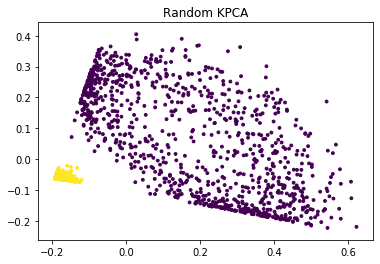

In [10]:
emb = KernelPCA(n_components=2, kernel='precomputed').fit_transform(K)
end = perf_counter()
t2 = end-start
start = perf_counter()
_ = KernelPCA(n_components=2, kernel='rbf', gamma=2).fit_transform(data)
end = perf_counter()
t1 = end-start
plt.scatter(emb.T[0],emb.T[1], s=8, c=colormap)
plt.title('Random KPCA')

In [11]:
print(t1,t2)

0.17753309999999978 0.1590669
